In [1]:
!hostname

spearhead3


# Image tiling

In [2]:
#Uses a fastai2 kernel.

#This is a hack; I have modified a package called "image_bbox_slicer" and here I add the 
#directory containing the modified code to my search path so I can import the modified package.
import sys
# insert at position 1, because 0 is the scriptath (or '' in REPL)
sys.path.insert(1,'/data2/home/egdod/jdev/image_bbox_tiler')
#sys.path.insert(1, '/home/john/.../image_bbox_tiler')

In [3]:
from pathlib import Path
from pascal_voc_writer import Writer
from PIL import Image
from torchvision.transforms.functional import pad as tvpad
import random
import pdb
from image_bbox_tiler import image_bbox_slicer as ibs
import re #regex
import subprocess
import pandas as pd
import zipfile
import shutil
import os

## Goal of this notebook
Our ultimate goal is to train an AI model to detect small features (animals) in large images (aerial photographs).  The relatively poor quality of the aerial images means that we can't afford to reduce the image resolution without losing the features we want to detect.  This is generically called a "small-object detection" problem and is an active area of research.  The way the problem is generally handled is to cut large images into smaller 'tiles'.

The images are roughly 6000 x 4000 pixels and we plan to use a tile size of 500 x 500, which means we will have 12 x 8 = 96 tiles per image, i.e., roughly 100 times as many tiles as images.  Even in the training images that contain objects of interest, the objects usually fall in just a few tiles.  For training purposes, there is no benefit to feeding the model vast numbers of empty tiles, but the model may generalize better if _some_ empty tiles are included in the training data.  Tiling images also requires that the corresponding bounding box annotations must be chopped up appropriately (transforming coordinates and preserving information about the class, attributes, etc.), and introduces the problem of boxes that fall across boundaries between tiles.  

**The specific goals of this notebook were:**
1. To make sure that all images (including empty ones) have annotation files;
2. To cut the images into tiles, and to tile the corresponding bounding boxes appropriately;
3. To allow overlap between tiles to ameliorate the problem of bounding boxes that fall on tile boundaries;
4. To omit most empty tiles and to save CPU cycles by not processing them, but allow some fraction of them to be sampled at random; and
5. To make it possible to discard tiles or change the label to "none" based on a threshold for minimum bounding box area.

### Directory structure (because I'll forget)

The general structure is this:
<pre>
/cdata/tanzania/annotated_images/TA25 + others (RR17, RR19, SL25) --annotated images
            |              \        \- _data/RKE/   
            |               \- AIAIA has original annotation zipfiles for all directories
            |- /temp  
                  |-/annotations -- contains annotations in subdirectories  
                  |-/tiled_annotations -- contains tiled annotations (no subdirectories)  
                  |-/tiled_images -- contains tiled annotations (no subdirectories)  
                  |-/temp --junk (used for moving unzipped files) 
</pre>
The annotation subdirectory names (`annotations/subname`) match the image subdirectories (`_data/RKE/subname`) to which they are related, but the image subdirectories may be further divided into additional subdirectories.

## Extract and divide annotations
This is necessary because annotation zipfiles can include images from more than one subdirectory.

Steps:
1. Figure out what subdirectories are represented in each annotation zipfile
2. Extract the zipfile and divide the annotation files into subdirectories based on the folder in each filename
3. Write missing annotation files for 'empty' images (see below for details)

In [4]:
#Set main paths
imagepath = Path('/cdata/tanzania/annotated_images') #Parent folder for images (had /RKE)
#imagepath = Path('/cdata/tanzania/TA25/_data') #Parent folder for images (had /RKE)
annotation_source_path = Path('/cdata/tanzania/annotated_images/AIAIA') #Where original zipped annotation files are
#annotation_source_path = Path('/cdata/tanzania/TA25') #Where original zipped annotation files are
annotationpath = Path('/cdata/tanzania/temp/annotations') #Destination parent folder for unzipped annotation files (where we want them to go)

In [5]:
#Get Pascal-VOC annotation files (in /TA25 itself)
annotation_files = [str(x) for x in annotation_source_path.iterdir() if str(x).find('voc_1.1') > 0 and x.suffix == '.zip'] #convert strings to Paths and get parent folder
annotation_files

['/cdata/tanzania/annotated_images/AIAIA/sl25-cfa-tnp_2013105-12-2020_08_11_07_45_04-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/rr17-cfa-zgf_20141104-08-2020_06_29_06_40_22-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/ta25-rke-20191201-2020_03_11_13_28_49-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/ta25-rke-20191127a-2020_03_06_09_05_38-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/ta25-rke-20191128a-2020_03_06_11_49_18-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/ta25-rke-20191202-3-2020_06_01_08_01_48-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/rr19-5el-20180920a-28a-2020_08_11_11_31_12-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/sl25-zgf_2013105-12-2020_08_11_12_04_49-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/rr17-sgr-twr_20141111-14-2020_08_11_13_14_30-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/ta25-twr-1201-3-2020_06_08_1

### Some utilities for finding subdirectories in annotation files

In [6]:
def get_zipfile_directories(zfile):
    """
    Returns a list of subdirectories found in the filenames in a zipfile
    """
    #Get the filenames inside the zipfile
    zpf = zipfile.ZipFile(zfile)
    fnames = zpf.namelist()
    #Get the directory of every file; and from there a list of unique directories
    fdirs = list(set([str(Path(f).parent) for f in fnames]))
    return (fdirs)

In [7]:
def get_zipfile_annotation_dirs(zfile,remove_list):
    
    fdirs = get_zipfile_directories(zfile)
    #filter out only those that start with 'Annotations'
    anndirs = [f for f in fdirs if f.split('/',1)[0] =='Annotations'] 
    #Clean the directory names by removing some roots
    subdirs = [clean_filepath(d,remove_list) for d in anndirs]
    return subdirs

In [8]:
#Create a flat list of all subdirectories found in all annotation files (called next)
def get_subdirs(annotation_files,remove_list):
    subdirs = []
    if not isinstance(annotation_files,list):
        return get_zipfile_annotation_dirs(annotation_files,remove_list)
    else:        
        for f in annotation_files:
            d = get_zipfile_annotation_dirs(f,remove_list)
            subdirs = subdirs + d
        return subdirs

In [9]:
#Removes elements from a filepath iteratively, only if they are in the first position.
#So to remove /Annotations or /Annotations/CVAT, remove_list should be ["Annotations","CVAT"] in that order.
def clean_filepath(fpath,remove_list):
    if not isinstance(remove_list,list):
        remove_list = list(remove_list)
    p = Path(fpath)
    for item in remove_list:
        if (p.parts[0]==item):
            p = Path(*p.parts[1:])
    return str(p)

In [11]:
#Check out the subdirectories in this batch of annotation files
rlist = ['Annotations','CVAT']
#rlist = []
get_subdirs(annotation_files,rlist)

['SL25/SL25-CFA-TNP_2013105-12',
 'RR17/RR17-CFA-ZGF_20141104-08',
 'TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_R',
 'TA25/_data/RKE/TA25-RKE-20191201B/TA25-RKE-20191201B_L',
 'TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L',
 'TA25/_data/RKE/TA25-RKE-20191127A/TA25-RKE-20191127A_L',
 'TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_L',
 'TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_R',
 'TA25/_data/RKE/TA25-RKE-20191203B/TA25-RKE-20191203B_R',
 'TA25/_data/RKE/TA25-RKE-20191203A/TA25-RKE-20191203A_L',
 'TA25/_data/RKE/TA25-RKE-20191202A/TA25-RKE-20191202A_L',
 'TA25/_data/RKE/TA25-RKE-20191202A/TA25-RKE-20191202A_R',
 'TA25/_data/RKE/TA25-RKE-20191203A/TA25-RKE-20191203A_R',
 'TA25/_data/RKE/TA25-RKE-20191203B/TA25-RKE-20191203B_L',
 'RR19/RR19-5EL-20180920A-28A',
 'SL25/SL25-ZGF_2013105-12',
 'RR17/RR17-SGR-TWR_20141111-14',
 'TA25/_data/TWR/TA25-TWR-20191201B/TA25-TWR-20191201B_R',
 'TA25/_data/TWR/TA25-TWR-20191202A/TA25-TWR-20191202A_R',
 'TA25/_data

### Clear the temporary directory and unzip annotations to it

In [12]:
def clear_directory(dir):
    """
    Clear a directory (erase both files and folders but leave the directory itself)
    """
    for filename in os.listdir(dir):
        file_path = os.path.join(dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))



In [13]:
#Unzips a single annotation zipfile into a temporary directory, complete with relative filepaths
#First we clear the temporary directory (delete files and folders)
def unzip_ann_file(ann_file,tempdir):
    """Unzip an annotation file into a temporary directory, complete with relative filepaths"""
    print("Clearing directory ",tempdir)
    clear_directory(tempdir)
        
    #Unzip the archive files into the temporary directory, in two steps
    #Warning: the -o flag can’t have spaces between it and the filename, and can only have ONE space before it
    outdir = '-o' + str(tempdir) 
    #Extract the files complete with relative filepaths (more stable than other methods tried)
    subprocess.call(["7z","x",ann_file,outdir]) #ann_file,outdir
    print("7z x ",ann_file,outdir)
    

### Copy existing annotation files to the annotationpath directory
Slighly complicated because of paths relative to different root directories.
#### TODO: Fix filename and filepath so they are identical in annotations with/without objects
Will have to dig into the XML to fix them.

In [14]:
#Copy existing annotations from the temp directory to the annotations directory.  
def copy_existing_annotations(tempdir,annotationpath,remove_list):
    fullpaths = list(tempdir.rglob("*.xml"))
    written = 0
    for fp in fullpaths:
        fullpath = str(fp) 
        relpath = Path(fp).relative_to(tempdir)
        cleanpath = clean_filepath(relpath,remove_list)
        to_path = str(Path(annotationpath)/cleanpath)
        shutil.copy(fullpath, to_path)
        written += 1
    print('Copied ',written,' files from temp to annotationpath')


## Fill in missing annotation files for 'empty' images
For each subdirectory represented in an annotation zipfile:
1. Get list of _all_ image filepaths in the associated subdirectory (recursive)
2. Get list of filepaths for _annotated_ images (ones that have associated annotation files)
3. Compare the lists to identify which images are missing annotation files
4. Use pascal_voc_writer to create an xml annotation file with no bounding box for each missing file

In [15]:
#1. Get list of all files processed from /ImageSets/Main/default.txt
#The default.txt file DOES contain path information, but we ignore it
def get_image_filepaths(tempdir,remove_list):
    file = open(Path(tempdir)/"ImageSets/Main/default.txt")
    lines = [line.strip() for line in file]
    file.close()
    flist = [clean_filepath(l,remove_list) for l in lines]
    return flist

In [16]:
#2. Get list of filenames for images that have associated annotation files
#We read this by searching the tempdir structure; then clean up a bit to match image names
def get_annotated_images(tempdir,remove_list):
    fullpaths = list(tempdir.rglob("*.xml"))
    relpaths = [str(Path(fp).relative_to(tempdir)) for fp in fullpaths]
    nosuffix = [str(Path(f).with_suffix('')) for f in relpaths] #Get rid of suffix
    ann_imgs = [clean_filepath(fp,remove_list) for fp in nosuffix] #Drop root directories (Annotations/CVAT)
    return ann_imgs

In [17]:
#3. Calculate the missing annotations by subtracting annotations from total files
#We're using full filepaths but dropping the file extensions
def calculate_missing_annotations(images,annotated_images):
    missing_ann = list(set(images) - set(annotated_images))
    assert (len(missing_ann)==(len(images) - len(annotated_images))), 'images - annotated_images != missing_ann.  Do filepaths match?'
    return(missing_ann)

In [18]:
#4. Use pascal_voc_writer to create a new empty annotation file for each image in a list
def write_empty_annotations(imagepath,missing_ann,an_dest):  
    nc = 0
    badlist = []
    if(len(missing_ann) > 0):
        for filestem in missing_ann:
            image = (Path(imagepath)/filestem).with_suffix('.jpg')
            try:
                im = Image.open(image)
            except FileNotFoundError:
                #print('Could not create xml file: image not found: ',image)
                bad_xml_file = (Path(an_dest)/filestem).with_suffix('.xml')
                badlist.append(str(bad_xml_file))
                next
            else:
                width, height = im.size
                writer = Writer(image, width, height) # Writer(path, width, height)
                outfile = str((Path(an_dest)/filestem).with_suffix('.xml'))
                writer.save(outfile)
                nc +=1
    print("   Created " + str(nc) + " new annotation files; ")
    if (len(badlist) > 0):
        print("Warning: No annotation file written for ",len(badlist)," xml files with no match to images.")
    return(badlist)

In [19]:
#Calculate which images are missing annotations in a directory, and write 'empty' annotations for them.
def add_missing_annotations(tempdir,imagedir,ann_dest,remove_list):
    """
    Calculates which images in a directory are missing annotation and writes 'empty' annotation files for them.
    Parameters:
     """
    print('Annotation directory: ',ann_dest)
    imgs = get_image_filepaths(tempdir,remove_list)
    print('   Total images: ', len(imgs))
    annotated_images = get_annotated_images(tempdir,remove_list)
    print('   Annotated images: ',len(annotated_images))
    missing_ann = calculate_missing_annotations(imgs,annotated_images)
    print('   Missing annotations: ',len(missing_ann))
    badlist = write_empty_annotations(imagedir,missing_ann,ann_dest)
    return(badlist)

## Process annotations

In [20]:
#Wrap it all into one function
def process_annotations(annotation_files,tempdir,imagedir,ann_dest,remove_list):
    #Create subfolders of the /cdata/tanzania/temp/annotations directory to put annotations in
    #The list is created directly from the annotation files.  Will not overwrite existing directories/files).
    subdirs = get_subdirs(annotation_files,remove_list)
    for sub in subdirs:
        p = annotationpath/sub
        p.mkdir(parents=True, exist_ok=True)
    subdirs

    #Add missing annotations.  No annotation will be created if the associated image file is missing
    badlist = [] #List of filenames for annotation files where no associated image can be found
    for ann_file in annotation_files:
        unzip_ann_file(ann_file,tempdir)
        copy_existing_annotations(tempdir,annotationpath,remove_list)
        blist = add_missing_annotations(tempdir,imagedir,ann_dest,remove_list)
        badlist = badlist + blist
    return badlist

In [26]:
#CALL: process_annotations()
tempdir = Path('/cdata/tanzania/temp/temp')
rlist = ['Annotations','CVAT']
badlist = process_annotations(annotation_files,tempdir,imagepath,annotationpath,rlist)
#Delete the bad xml files (which have no matching image) from annotationpath
for f in badlist:
    f.unlink()

Clearing directory  /cdata/tanzania/temp/temp
7z x  /cdata/tanzania/annotated_images/AIAIA/sl25-cfa-tnp_2013105-12-2020_08_11_07_45_04-pascal_voc_1.1.zip -o/cdata/tanzania/temp/temp
Copied  382  files from temp to annotationpath
Annotation directory:  /cdata/tanzania/temp/annotations
   Total images:  968
   Annotated images:  382
   Missing annotations:  586
   Created 586 new annotation files; 
Clearing directory  /cdata/tanzania/temp/temp
7z x  /cdata/tanzania/annotated_images/AIAIA/rr17-cfa-zgf_20141104-08-2020_06_29_06_40_22-pascal_voc_1.1.zip -o/cdata/tanzania/temp/temp
Copied  320  files from temp to annotationpath
Annotation directory:  /cdata/tanzania/temp/annotations
   Total images:  484
   Annotated images:  320
   Missing annotations:  164
   Created 164 new annotation files; 
Clearing directory  /cdata/tanzania/temp/temp
7z x  /cdata/tanzania/annotated_images/AIAIA/ta25-rke-20191201-2020_03_11_13_28_49-pascal_voc_1.1.zip -o/cdata/tanzania/temp/temp
Copied  85  files from 

In [ ]:
# Exception: Each image in `/cdata/tanzania/annotated_images/RR19/RR19-5EL-20180920A-28A` must have its 
# corresponding XML file in `/cdata/tanzania/temp/annotations/RR19/RR19-5EL-20180920A-28A` with the same file name.

## Manually delete some problematic nonmatching files
#### TODO: Perhaps add this to annotation processing so it happens automatically.

In [21]:
def find_nonmatching_files(imagepath,annotationpath,folder):
    #Get image files
    impth = imagepath/folder
    imlist = list(impth.glob('*.jpg'))
    imfiles = [str(Path(im).relative_to(imagepath).with_suffix('')) for im in imlist]
    #Get annotation files that should match
    anpth = Path(annotationpath)/folder
    anlist = list(anpth.glob('*.xml'))
    anfiles = [str(Path(af).relative_to(annotationpath).with_suffix('')) for af in anlist]
    image_hasno_xml = [f for f in imfiles if f not in anfiles]
    xml_hasno_image = [f for f in anfiles if f not in imfiles]
    return (image_hasno_xml,xml_hasno_image)
    

In [ ]:
#Call it
(image_hasno_xml,xml_hasno_image) = find_nonmatching_files(imagepath,annotationpath,'RR19/RR19-5EL-20180920A-28A')

In [ ]:
#Delete files from annotationpath (but this does not affect the original zipfile)
for f in xml_hasno_image:
    xmlpath = annotationpath/Path(f).with_suffix('.xml')
    xmlpath.unlink()
    print('Deleted ',xmlpath)

# Tile images
For this step, I forked a Python package called **'image_bbox_slicer'** and named the new package **'image_bbox_tiler'** to make it distinguishable for import.  The main changes made were:
1. The original package discarded any pixels that fall outside an even multiple of the tile size.  That wastes a lot of data if the tiles are large.  Each image is now padded with zeros out to an even multiple of tile size _before_ tiling it so no data is lost, and the padding works correctly if the images are of different sizes.  
2. The tile overlap math, tile size calculations, and row and column indexes were fixed to make them precisely correct (instead of various rough approximations, truncations, etc.);
3. Fixed a problem with float values in annotations that caused a display error;
4. Built in the capability to sample a variable proportion of empty tiles;
5. Revamped tile naming so that tiles are named with row and column indexes to make future reassembly easier.
6. Modified the code so tiles that are not saved are not created in the first place, to save memory and CPU cycles;
7. Made the tiled images display in the correct row and column relative to the original image, and to show padding (the placement of tiles in the original package was approximate, relative to the source image).
8. Images (but not yet annotations) can now be found by recursive search; i.e., the `im_src` directory can be pointed at a parent directory that contains subdirectories with images in them.
9. Bounding boxes fragments that are smaller than tile overlap in the appropriate dimension can be excluded (see next)

## Excluding bounding box fragments
The problem: When tiling images to generate training data, the associated bounding boxes must also be tiled.  Splitting bounding boxes across tiles creates box fragments on one side of a tile boundary.  For a deep learning model, it is desirable to exclude small box fragments because they are very unlikely to contain a recognizable object. Overlapping the tiles helps to reduce the problem, but does not eliminate fragments.  

**The method implemented here allows the user to ensure that no feature smaller than the tile overlap will be excluded, while getting rid of all smaller fragments.**

In the diagram below, the large box is a tile and the overlap with adjacent tiles is shown by dotted lines. The `exclude_fragments=True` option would exclude all three bounding boxes shown below in yellow (A, B, and C) from the tile.  For simplicity, bounding boxes are only shown on the bottom and right of the tile in the image, but the behavior is identical for the top and left edges of the tile, respectively.

**Decision rule:**
Given that a rectangular bounding box can have 1, 2, or 4 (but not 3) corners inside a rectangular tile if they are aligned:
- If 1 corner of the box is in the tile: 
    - if (box_w < tile_overlap_w) or (box_h < tile_overlap_h): discard the box
- If 2 corners of the box are in the tile:
    - if the box is on the left or right side of the tile and (box_w < tile_overlap_w): discard  
    - if the box is on the top or bottom of the tile and (box_h < tile_overlap_h): discard
- Include the bounding box in all other cases.

In the figure, the green bounding boxes would all be included in the annotations for this tile.  Box D will be recorded in this tile only; box E will be sliced in half and will be recorded (with overlap) in this tile and the tile below it.  Box F will be recorded in both this tile and the tile below it.  Box G will appear on this tile and in the tile to the right of it (minus the part to the left of the dotted line). Boxes A, B and C will not be recorded in this tile, but _will_ be recorded on adjacent tiles.  


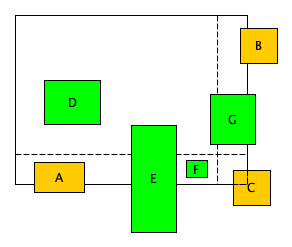

## Tile two test images (don't skip this step)

In [ ]:
rlist = ['Annotations','CVAT']
subdirs = get_subdirs(annotation_files,rlist)
subdirs

In [24]:
#TEMPORARY: set paths to "test2" directory
im_src = 'test2/images' 
an_src = 'test2/annotations'
im_dst = 'test2/tiled_images'
an_dst = 'test2/tiled_annotations'
badlist = []

In [25]:
#Instantiate the slicer
slicer = ibs.Slicer()
slicer.config_dirs(img_src=im_src, ann_src=an_src,img_dst=im_dst, ann_dst=an_dst,badlist=badlist) 

In [26]:
#Configure the slicer
slicer.ignore_empty_tiles = True #Discards empty tiles, EXCEPT that if sample_empty > 0 it will sample the empties anyway.
slicer.keep_partial_labels = True #Does not discard bboxes that cross tile boundaries
slicer.save_before_after_map = True #Writes a csv file with filename/tilenames
slicer.exclude_fragments = False #Excludes bounding box fragments if they are smaller than tile overlap in appropriate direction

#tile_overlap: float (percentage of tile overlap between two consecutive strides).
#Image 2 is (6490, 4510) pixels

In [ ]:
#Slice away!
slicer.slice_by_size(tile_size=(500,500), tile_overlap=0.20,empty_sample=.005)

In [ ]:
#Pick an image and its tiles at random (BE PATIENT -- the tiled matrix is very slow to render)
slicer.visualize_sliced_random()

# Factory tiling
**Note: the Slicer is configured inside a loop below, since we have to pass it different directories.**

In [22]:
rlist = ['Annotations','CVAT']
subdirs = get_subdirs(annotation_files,rlist)
subdirs

['SL25/SL25-CFA-TNP_2013105-12',
 'RR17/RR17-CFA-ZGF_20141104-08',
 'TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_R',
 'TA25/_data/RKE/TA25-RKE-20191201B/TA25-RKE-20191201B_L',
 'TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L',
 'TA25/_data/RKE/TA25-RKE-20191127A/TA25-RKE-20191127A_L',
 'TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_L',
 'TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_R',
 'TA25/_data/RKE/TA25-RKE-20191203B/TA25-RKE-20191203B_R',
 'TA25/_data/RKE/TA25-RKE-20191203A/TA25-RKE-20191203A_L',
 'TA25/_data/RKE/TA25-RKE-20191202A/TA25-RKE-20191202A_L',
 'TA25/_data/RKE/TA25-RKE-20191202A/TA25-RKE-20191202A_R',
 'TA25/_data/RKE/TA25-RKE-20191203A/TA25-RKE-20191203A_R',
 'TA25/_data/RKE/TA25-RKE-20191203B/TA25-RKE-20191203B_L',
 'RR19/RR19-5EL-20180920A-28A',
 'SL25/SL25-ZGF_2013105-12',
 'RR17/RR17-SGR-TWR_20141111-14',
 'TA25/_data/TWR/TA25-TWR-20191201B/TA25-TWR-20191201B_R',
 'TA25/_data/TWR/TA25-TWR-20191202A/TA25-TWR-20191202A_R',
 'TA25/_data

In [23]:
#Set main paths (repeated here for convenience when restarting the kernel)
#Set main paths
imagepath = Path('/cdata/tanzania/annotated_images') # Parent folder for all images
annotation_source_path = Path('/cdata/tanzania/annotated_images/AIAIA') #Where original zipped annotation files are
annotationpath = Path('/cdata/tanzania/temp/annotations') #Destination parent folder for unzipped annotation files (where we want them to go)

In [24]:
#Get Pascal-VOC annotation files
annotation_files = [str(x) for x in annotation_source_path.iterdir() if str(x).find('pascal') > 0 and x.suffix == '.zip'] #convert strings to Paths and get parent folder
annotation_files

['/cdata/tanzania/annotated_images/AIAIA/sl25-cfa-tnp_2013105-12-2020_08_11_07_45_04-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/rr17-cfa-zgf_20141104-08-2020_06_29_06_40_22-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/ta25-rke-20191201-2020_03_11_13_28_49-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/ta25-rke-20191127a-2020_03_06_09_05_38-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/ta25-rke-20191128a-2020_03_06_11_49_18-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/ta25-rke-20191202-3-2020_06_01_08_01_48-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/rr19-5el-20180920a-28a-2020_08_11_11_31_12-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/sl25-zgf_2013105-12-2020_08_11_12_04_49-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/rr17-sgr-twr_20141111-14-2020_08_11_13_14_30-pascal_voc_1.1.zip',
 '/cdata/tanzania/annotated_images/AIAIA/ta25-twr-1201-3-2020_06_08_1

In [111]:
#CALL: TILE ALL IMAGES

#Set up image paths. The destination (where tiles go) is the same for all files; sources change each time.

#Destinations
im_dst = '/cdata/tanzania/temp/tiled_images'
an_dst = '/cdata/tanzania/temp/tiled_annotations'

#Sources
subdirs = get_subdirs(annotation_files,rlist)

for sub in subdirs:
    
    #Set image and annotation sourcepaths
    im_src = str(imagepath/sub) #Put together the filename
    an_src = str(annotationpath/sub)
    
    #Instantiate the slicer
    slicer = ibs.Slicer()
    slicer.config_dirs(img_src=im_src, ann_src=an_src,img_dst=im_dst, ann_dst=an_dst,badlist=badlist) 
    
    #Configure the slicer
    slicer.ignore_empty_tiles = True #Discards empty tiles, EXCEPT that if sample_empty > 0 it will sample the empties anyway.
    slicer.keep_partial_labels = True #Does not discard bboxes that cross tile boundaries
    slicer.save_before_after_map = True #Writes a csv file with filename/tilenames
    slicer.exclude_fragments = True #Excludes bounding box fragments if they are smaller than tile overlap in appropriate direction
    
    #Slice away. Should produce 4 lines of output per subdirectory. 
    slicer.slice_by_size(tile_size=(500,500), tile_overlap=0.20,empty_sample=.005)
 

Obtained 3142 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 3142 image slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_images


/data2/home/egdod/jdev/image_bbox_tiler/image_bbox_slicer/helpers.py:113: UserWarning: Destination directory /cdata/tanzania/temp/tiled_images already has some files
  warnings.warn(
/data2/home/egdod/jdev/image_bbox_tiler/image_bbox_slicer/helpers.py:113: UserWarning: Destination directory /cdata/tanzania/temp/tiled_annotations already has some files
  warnings.warn(


Obtained 2356 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 2356 image slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_images
Obtained 228 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 228 image slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_images
Obtained 425 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 425 image slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_images
Obtained 176 annotation slices!
Successfully saved the mapping between files before and after slicing at /cdata/tanzania/temp/tiled_annotations
Obtained 176 image s

In [60]:
str(annotationpath/sub)

'/cdata/tanzania/temp/annotations/SL25/SL25-CFA-TNP_2013105-12'

### Visualize a random sliced image

**TODO: FIX MAPPER**.  This code works but relies on a `mapper.txt` file to find files, and the original code writes two different mappers; one to `/img_dst` and the other to `/ann_dst`.  Both get overwritten when I execute the code on multiple source directories.  These need to be fixed; probably should write mapper to both `/img_src` and `/ann_src` (not destination) and also accumulate a master mapper file and write it to `/tiled_annotations`.  

In [32]:
subdirs

['SL25/SL25-CFA-TNP_2013105-12',
 'RR17/RR17-CFA-ZGF_20141104-08',
 'TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_R',
 'TA25/_data/RKE/TA25-RKE-20191201B/TA25-RKE-20191201B_L',
 'TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L',
 'TA25/_data/RKE/TA25-RKE-20191127A/TA25-RKE-20191127A_L',
 'TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_L',
 'TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_R',
 'TA25/_data/RKE/TA25-RKE-20191203B/TA25-RKE-20191203B_R',
 'TA25/_data/RKE/TA25-RKE-20191203A/TA25-RKE-20191203A_L',
 'TA25/_data/RKE/TA25-RKE-20191202A/TA25-RKE-20191202A_L',
 'TA25/_data/RKE/TA25-RKE-20191202A/TA25-RKE-20191202A_R',
 'TA25/_data/RKE/TA25-RKE-20191203A/TA25-RKE-20191203A_R',
 'TA25/_data/RKE/TA25-RKE-20191203B/TA25-RKE-20191203B_L',
 'RR19/RR19-5EL-20180920A-28A',
 'SL25/SL25-ZGF_2013105-12',
 'RR17/RR17-SGR-TWR_20141111-14',
 'TA25/_data/TWR/TA25-TWR-20191201B/TA25-TWR-20191201B_R',
 'TA25/_data/TWR/TA25-TWR-20191202A/TA25-TWR-20191202A_R',
 'TA25/_data

In [35]:
len(subdirs)
subdirs[19]

'TA25/_data/TWR/TA25-TWR-20191203A/TA25-TWR-20191203A_R'

In [38]:
#Note: this will look at the last subdirectory tiled

sub = subdirs[19]
#Test source (a single subdirectory with 17 images)
#sub = 'TA25-RKE-20191203B'

#Destinations
im_dst = '/cdata/tanzania/temp/tiled_images'
an_dst = '/cdata/tanzania/temp/tiled_annotations'

#Set image and annotation sourcepaths
im_src = str(imagepath/sub) #Put together the filename
an_src = str(annotationpath/sub)

#Instantiate the slicer
slicer = ibs.Slicer()
slicer.config_dirs(img_src=im_src, ann_src=an_src,img_dst=im_dst, ann_dst=an_dst)

#Configure the slicer
slicer.ignore_empty_tiles = True #Discards empty tiles, EXCEPT that if sample_empty > 0 it will sample the empties anyway.
slicer.keep_partial_labels = True #Does not discard bboxes that cross tile boundaries
slicer.save_before_after_map = True #Writes a csv file with filename/tilenames
slicer.exclude_fragments = True #Excludes bounding box fragments if they are smaller than tile overlap in appropriate directiona

In [30]:
sub

'TA25/_data/TWR/TA25-TWR-20191202A/TA25-TWR-20191202A_R'

In [ ]:
slicer.visualize_sliced_random(an_dst)

# Code scraps

## libvips (which has a Python wrapper called pyvips)
**Howard, I'm thinking that we might want to use libvips when we do production tiling of non-annotated images, since there won't be any bounding boxes to worry about and it's fast.**
The library is designed for working with very large images without blowing out RAM; it's fast and streamlined.  But libvips does not have a perfect tiling function; instead the author recommends the `dzsave` function, which is designed for making image pyramids for tiled imagery.
The author answered some of my questions on StackExchange: 
1. Tile names are in the form `column_row.tif` if you save to the deepzoom format; 
2. "`dzsave` outputs deepzoom / google maps / zoomify / iiif pyramids, so you get a choice from those naming conventions. 
3. "Overlaps are just pixels that are shared between tiles, so eg. with overlap 1, the rightmost two columns in tile 0_0 are identical to the leftmost two column in tile 1_0. Set overlap to 0 if you want non-overlapping tiles."
https://libvips.github.io/libvips/API/current/Making-image-pyramids.md.html

```bash
vips dzsave hugefile.tif outdir --depth one --tile-size 512 --overlap 0 --suffix .tif
    --depth one #slices a large image into tiles, rather than making a pyramid.
    overlap #Tile overlap in pixels--warning: input parameter 'gint' has a default of 1!
    --background 0 #black
```

Comparing libvips to ImageMagick, libvips seems faster:

In [27]:
# $ time convert -crop 512x512 +repage huge.tif x/image_out_%d.tif
# real    0m5.623s
# user    0m2.060s
# sys     0m2.148s
# $ time vips dzsave huge.tif x --depth one --tile-size 512 --overlap 0 --suffix .tif
# real    0m1.643s
# user    0m1.668s
# sys     0m1.000s

More libvips code examples

In [28]:
# import pyvips

# image = pyvips.Image.new_from_file('some-image.jpg', access='sequential')
# image *= [1, 2, 1]
# mask = pyvips.Image.new_from_array([[-1, -1, -1],
#                                     [-1, 16, -1],
#                                     [-1, -1, -1]
#                                    ], scale=8)
# image = image.conv(mask, precision='integer')
# image.write_to_file('x.jpg')

ImageMagick code for tiling **and renaming tiles by row and column**

In [ ]:
magick hugeimage.png -crop 256x256 -set filename:f "tile_%[fx:page.x],%[fx:page.y]_%[w]x%[h]" "%

...and lastly, **a custom method for reducing the memory impact when using ImageMagick**.

In [ ]:
# #This version puts row and col in the filename (good for reassembly!).  Trick is to divide coordinate by cropsize.  
# #He added 1001 instead of 1 to get constant-width numbers in the output. Nice!
# #!/bin/bash
# /usr/bin/convert bigimage.jpg -crop 256x256 \
#   -set filename:tile "%[fx:page.x/256+1001]_%[fx:page.y/256+1001]" \
#     +repage +adjoin "tiled_%[filename:tile].jpg"
    
# convert -verbose images\0.png -crop 256x256 +adjoin -background white -extent 256x256 -set filename:tile "%%[fx:floor(page.x/256)]_%%[fx:floor(page.y/256)]" +repage "tiles\0_%%[filename:tile].png"

# #OR a 3-step method:
# #1. convert to mpc (ImageMagick's native format)
# convert -monitor -limit area 2mb myLargeImg.tif myLargeImg.mpc
# #2. Bash program (potentially useful anyway)
# #!/bin/bash
#  src=$1
#  width=`identify -format %w $src`
#  limit=$[$width / 256]
#  echo "count = $limit * $limit = "$((limit * limit))" tiles"
#  limit=$((limit-1))
#  for x in `seq 0 $limit`; do
#    for y in `seq 0 $limit`; do
#      tile=tile-$x-$y.png
#      echo -n $tile
#      w=$((x * 256))
#      h=$((y * 256))
#      convert -debug cache -monitor $src -crop 256x256+$w+$h $tile
#    done
#  done

# #3. call the bash program
#  sh ./tiler.sh myLargeImg.mpc
    

# Other random tidbits

In [43]:
#not needed, but could be useful anyway
#Find the image file directories that go with the annotation file
imageroot = Path('/cdata/tanzania/TA25/_data/RKE')/subdirs[0]
annfile_imagepath = imageroot/subdirs[0]
ann_target_folders = [ x for x in annfile_imagepath.glob(subdirs[0]+'*')]
ann_target_folders

[PosixPath('/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_R'),
 PosixPath('/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_L')]

In [ ]:
#Not needed but the separate counts for each directory are nice
tot_images = []

for d in range(0,len(ann_target_folders)):
    imgs = None
    imgs = get_image_files(ann_target_folders[d])
    imgs = [str(im) for im in imgs]
    print(str(ann_target_folders[d]),len(imgs),'image files')
    tot_images = tot_images + imgs #Join lists
    
print('Total images: ',len(tot_images))

In [248]:
#Create a little database associating annotation files with annotation subdirectories and image directories.
#Note: most values are Pathlib Paths, not strings.
# def find_target_dirs(imagepath,annotationpath,annotation_files):
#     """
#     Uses the annotation filename to set a target directory for unzipping annotation files and
#     to determine the parent directory for the corresponding images.  Returns a little database.
#     """
#     records = []
#     #Get subdirectories from the annotation file names (take the stem and drop "_pascalvoc")
#     subdir_dict = get_subdir_dict(annotation_files)
#     for f in annotation_files:
#         #find the subdirectory in the filename and set it as the destination for unzipped files
#         for sub in subdir_dict[f]:
#             dest = Path('/cdata/tanzania/temp/annotations')/sub
#             target_image_dir = imagepath/sub
#             records.append([f,sub,dest,target_image_dir])            
#     ann_db = pd.DataFrame(records, columns=['ann_sourcefile', 'subdirectory','ann_dest_dir','target_image_dir'])
#     return (ann_db)